# Developing the Script 

In [18]:
%load_ext autoreload
%autoreload 2

In [2]:
from mcmc_utils_copy import main, get_cov, grab_data, corner_plot, check_convergence
from multiprocessing import Pool, cpu_count
import emcee
import corner
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

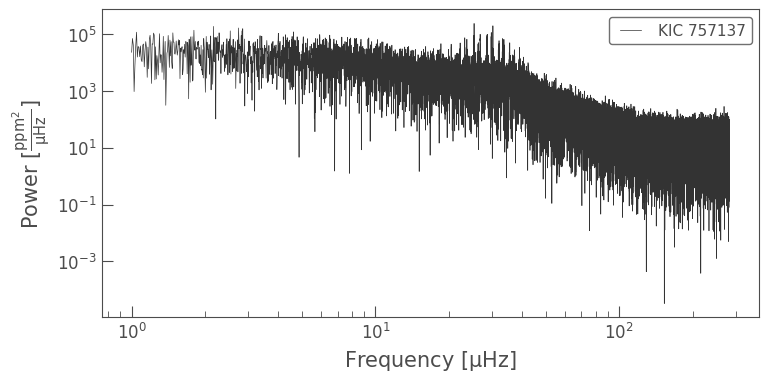

In [8]:
search = lk.search_lightcurve('KIC 757137', author='Kepler')
lc = search.download_all().stitch(lambda x: x.normalize('ppm'))
NYQUIST = 283.2114
valid = np.isfinite(lc.flux_err) & (lc.flux_err > 0)

pd = lc[valid].to_periodogram(normalization = 'psd', minimum_frequency = 1, maximum_frequency = NYQUIST)
pd.plot(scale = "log")

freq = pd.frequency.to_value()
powers = pd.power.to_value()

In [10]:
theta = [29.36604 , 24262.86035 , 16229.56210, 9770.21985, 3.41096, 10]
bump = [1e-2 , 1e-2 , 1e-2 , 1e-2 ,1e-2, 1e-2]

ndim = 6 
nwalkers = 15

initial = np.array(theta)
p0 = [initial + bump * np.random.randn(ndim) for i in range(nwalkers)]

data = (freq,  powers)

In [11]:
with Pool(cpu_count()) as pool:
    sampler, pos, prob, state = main(p0, lnprob, data, pool)

Running burn-in...


100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


Running production...


100%|██████████| 5000/5000 [07:26<00:00, 11.21it/s]


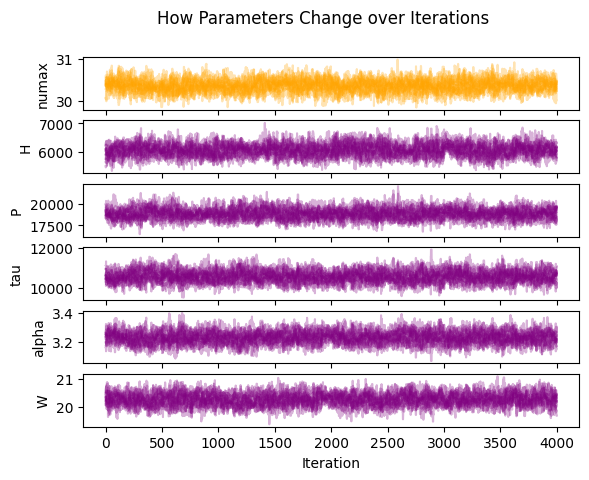

In [14]:
chain = sampler.get_chain(flat=False, discard = 1000)

fig = plt.figure() 
fig.add_subplot(6, 1, 1) 

plt.plot(chain[:, :, 0], color='orange', alpha=0.3)
plt.ylabel('numax')

fig.add_subplot(6, 1, 2) 
plt.plot(chain[:, :, 1], color='purple', alpha=0.3)
plt.ylabel('H')

fig.add_subplot(6, 1, 3) 
plt.plot(chain[:, :, 2], color='purple', alpha=0.3)
plt.ylabel('P')

fig.add_subplot(6, 1, 4) 
plt.plot(chain[:, :, 3], color='purple', alpha=0.3)
plt.ylabel('tau')

fig.add_subplot(6, 1, 5) 
plt.plot(chain[:, :, 4], color='purple', alpha=0.3)
plt.ylabel('alpha')

fig.add_subplot(6, 1, 6) 
plt.plot(chain[:, :, 5], color='purple', alpha=0.3)
plt.ylabel('W')

plt.xlabel('Iteration')
plt.suptitle("How Parameters Change over Iterations")
plt.show()

# Ok now we can use the table 

In [37]:
table = pd.read_csv("/Users/student/Downloads/merged_data.csv")
table.columns

Index(['KIC', 'M', 'R', 'Teff', 'FeH', 'e_M', 'e_R', 'e_Teff', 'e_FeH',
       'nu_max', 'Delta_nu', 'e_nu_max', 'e_Delta_nu', 'H', 'P', 'tau',
       'alpha', 'taue', 'sigma2', 'e_H', 'e_P', 'e_tau', 'e_alpha', 'e_taue',
       'e_sigma2', 'phase', 'e_phase', 'KepMag', 'e_KepMag'],
      dtype='object')

In [49]:
theta = np.append(table.iloc[0][['nu_max', 'H', 'P', 'tau', 'alpha']], 10)
initial = np.array(theta)
p0 = [initial + bump * np.random.randn(ndim) for i in range(nwalkers)]

In [54]:
with Pool(cpu_count()) as pool:
    sampler, pos, prob, state = main(p0, lnprob, data, pool)

Running burn-in...


100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s]


Running production...


100%|██████████| 5000/5000 [07:08<00:00, 11.67it/s]


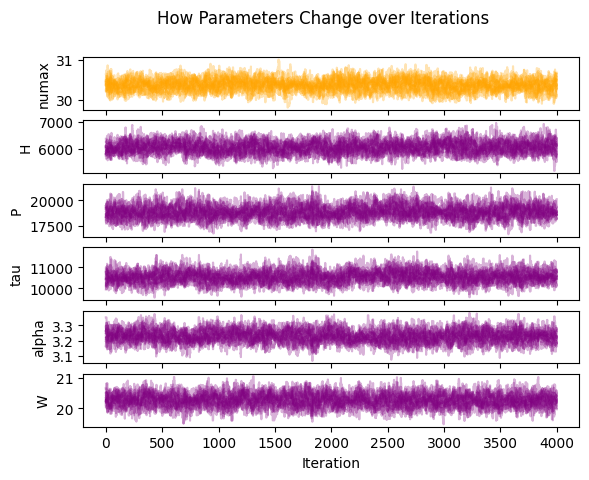

In [55]:
chain = sampler.get_chain(flat=False, discard = 1000)

fig = plt.figure() 
fig.add_subplot(6, 1, 1) 

plt.plot(chain[:, :, 0], color='orange', alpha=0.3)
plt.ylabel('numax')

fig.add_subplot(6, 1, 2) 
plt.plot(chain[:, :, 1], color='purple', alpha=0.3)
plt.ylabel('H')

fig.add_subplot(6, 1, 3) 
plt.plot(chain[:, :, 2], color='purple', alpha=0.3)
plt.ylabel('P')

fig.add_subplot(6, 1, 4) 
plt.plot(chain[:, :, 3], color='purple', alpha=0.3)
plt.ylabel('tau')

fig.add_subplot(6, 1, 5) 
plt.plot(chain[:, :, 4], color='purple', alpha=0.3)
plt.ylabel('alpha')

fig.add_subplot(6, 1, 6) 
plt.plot(chain[:, :, 5], color='purple', alpha=0.3)
plt.ylabel('W')

plt.xlabel('Iteration')
plt.suptitle("How Parameters Change over Iterations")
plt.show()

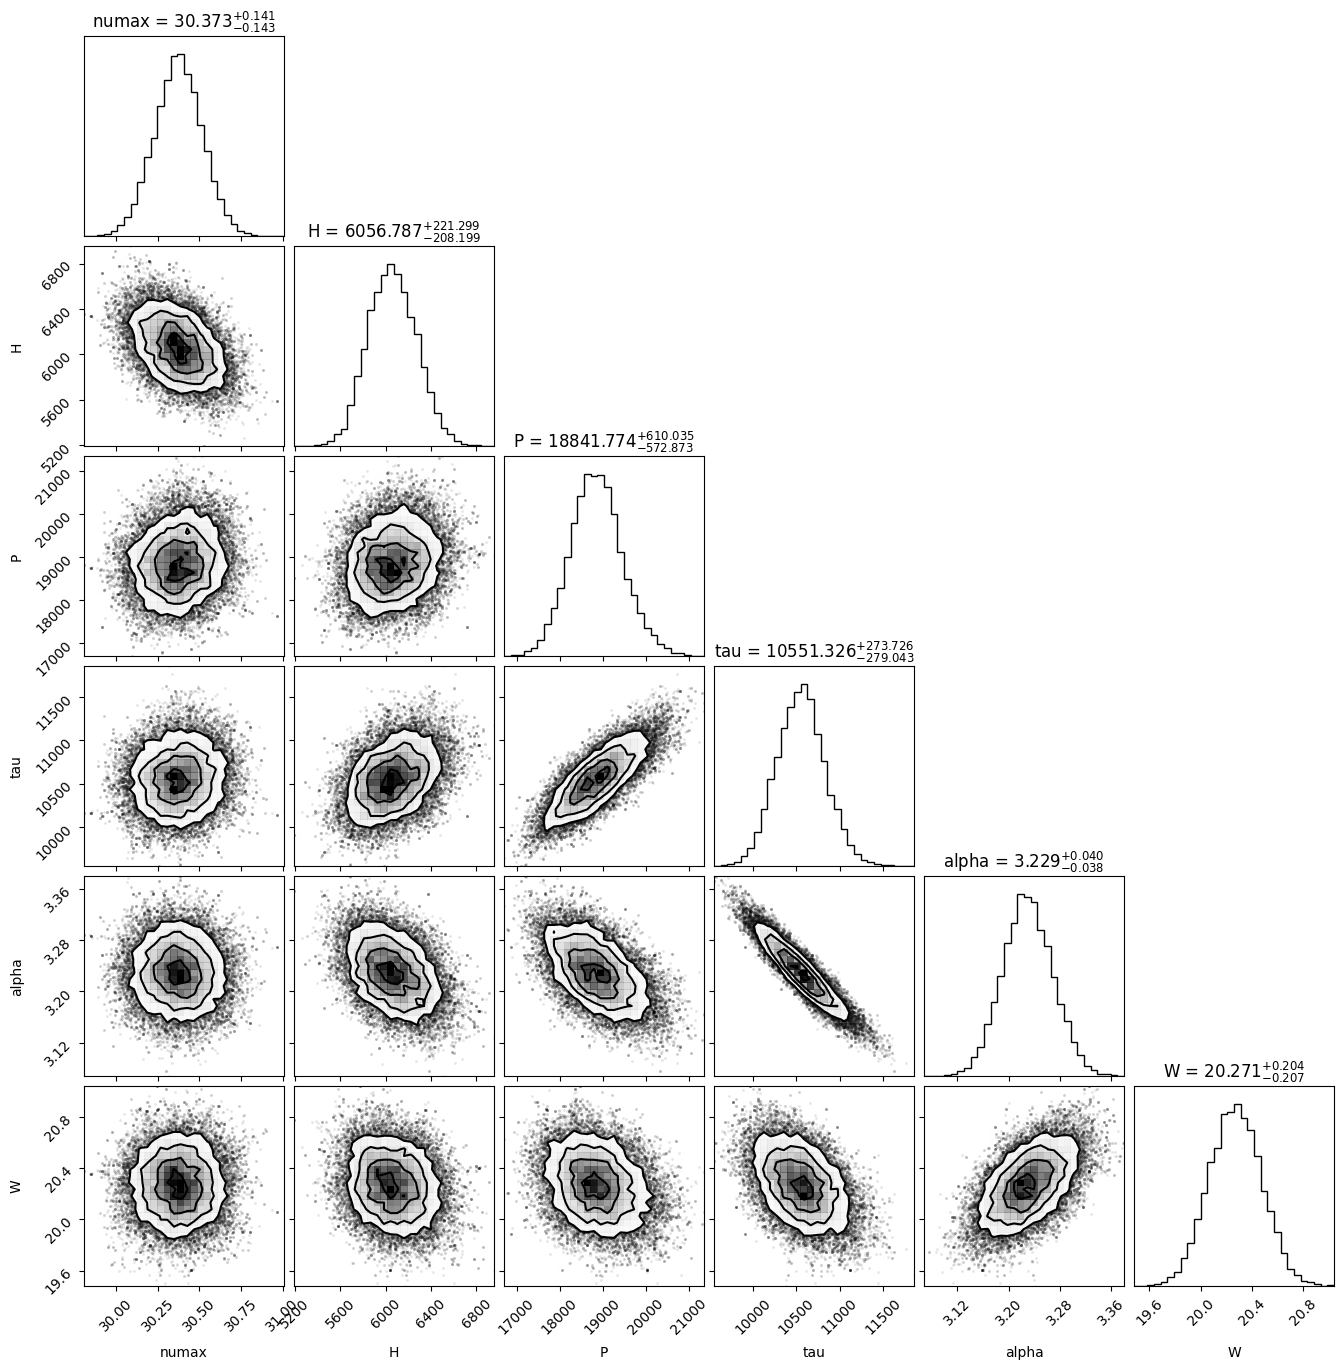

In [61]:
fig = corner.corner(sampler.get_chain(flat=True, discard = 1000), labels=["numax", "H", "P", "tau", "alpha", "W"], show_titles=True, title_fmt=".3f", bins=30)
plt.show()

In [77]:
sampler_list = []
cov_list = []

for index, row in table.head(5).iterrows():

    data = grab_data(int(row["KIC"]))

    theta = np.append(row[['nu_max', 'H', 'P', 'tau', 'alpha']], 10)
    initial = np.array(theta)
    p0 = [initial + bump * np.random.randn(ndim) for i in range(nwalkers)]

    with Pool(cpu_count()) as pool:
        sampler, pos, prob, state = main(p0, data, pool)

    sampler_list.append(sampler)
    cov_list.append(get_cov(sampler, show = False))

Running burn-in...


100%|██████████| 1000/1000 [01:11<00:00, 14.05it/s]


Running production...


 32%|███▏      | 1615/5000 [01:33<03:15, 17.32it/s]
Process SpawnPoolWorker-20:
Process SpawnPoolWorker-17:


emcee: Exception while calling your likelihood function:
  params: emcee: Exception while calling your likelihood function:
  params: [3.05405464e+01 5.78978007e+03 1.89122087e+04 1.01821290e+04
 3.30825037e+00 2.04472034e+01]
  args: (array([  1.        ,   1.00793022,   1.01586045, ..., 283.1891155 ,
       283.19704572, 283.20497595], shape=(35587,)), array([2.31287057e+04, 7.04883924e+04, 4.12403884e+04, ...,
       1.59610174e+01, 4.98580333e+01, 1.34998696e+01], shape=(35587,)))
  kwargs: {}
  exception:
[3.07432950e+01 5.79657972e+03 1.87459971e+04 1.04001038e+04
 3.27078672e+00 2.04652319e+01]
  args: (array([  1.        ,   1.00793022,   1.01586045, ..., 283.1891155 ,
       283.19704572, 283.20497595], shape=(35587,)), array([2.31287057e+04, 7.04883924e+04, 4.12403884e+04, ...,
       1.59610174e+01, 4.98580333e+01, 1.34998696e+01], shape=(35587,)))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [72]:
data = grab_data(int(table.iloc[1]["KIC"]))

theta = np.append(table.iloc[1][['nu_max', 'H', 'P', 'tau', 'alpha']], 10)
initial = np.array(theta)
p0 = [initial + bump * np.random.randn(ndim) for i in range(nwalkers)]

with Pool(cpu_count()) as pool:
    sampler, pos, prob, state = main(p0, data, pool)

Running burn-in...


100%|██████████| 1000/1000 [00:20<00:00, 48.96it/s]


Running production...


100%|██████████| 5000/5000 [01:36<00:00, 51.61it/s]


In [ ]:
table

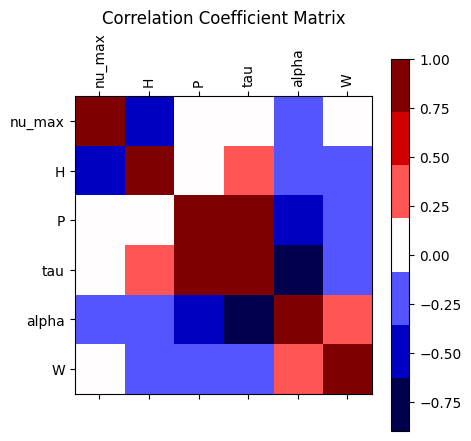

array([[ 1.        , -0.44932701,  0.08128761,  0.12936047, -0.11137876,
        -0.03804842],
       [-0.44932701,  1.        ,  0.0960017 ,  0.27678198, -0.30995402,
        -0.11478002],
       [ 0.08128761,  0.0960017 ,  1.        ,  0.76244715, -0.45771047,
        -0.18885294],
       [ 0.12936047,  0.27678198,  0.76244715,  1.        , -0.90066587,
        -0.34578976],
       [-0.11137876, -0.30995402, -0.45771047, -0.90066587,  1.        ,
         0.42943764],
       [-0.03804842, -0.11478002, -0.18885294, -0.34578976,  0.42943764,
         1.        ]])

In [74]:
get_cov(sampler, show = True)

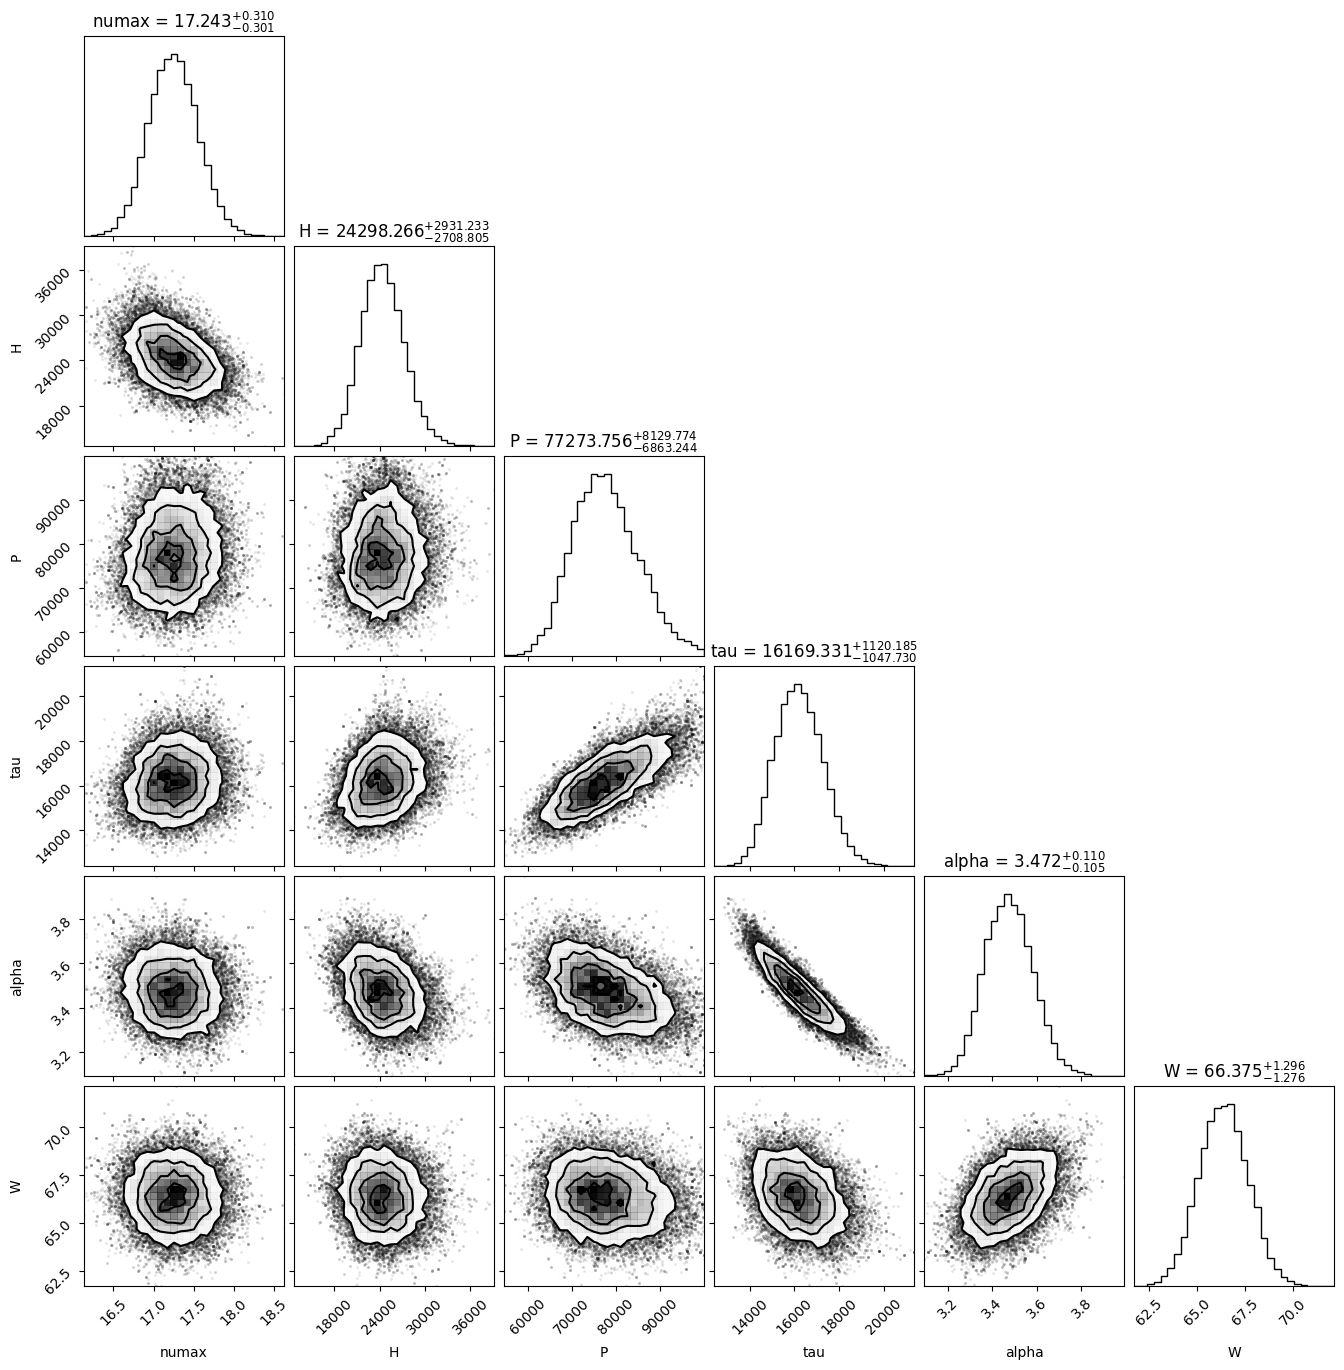

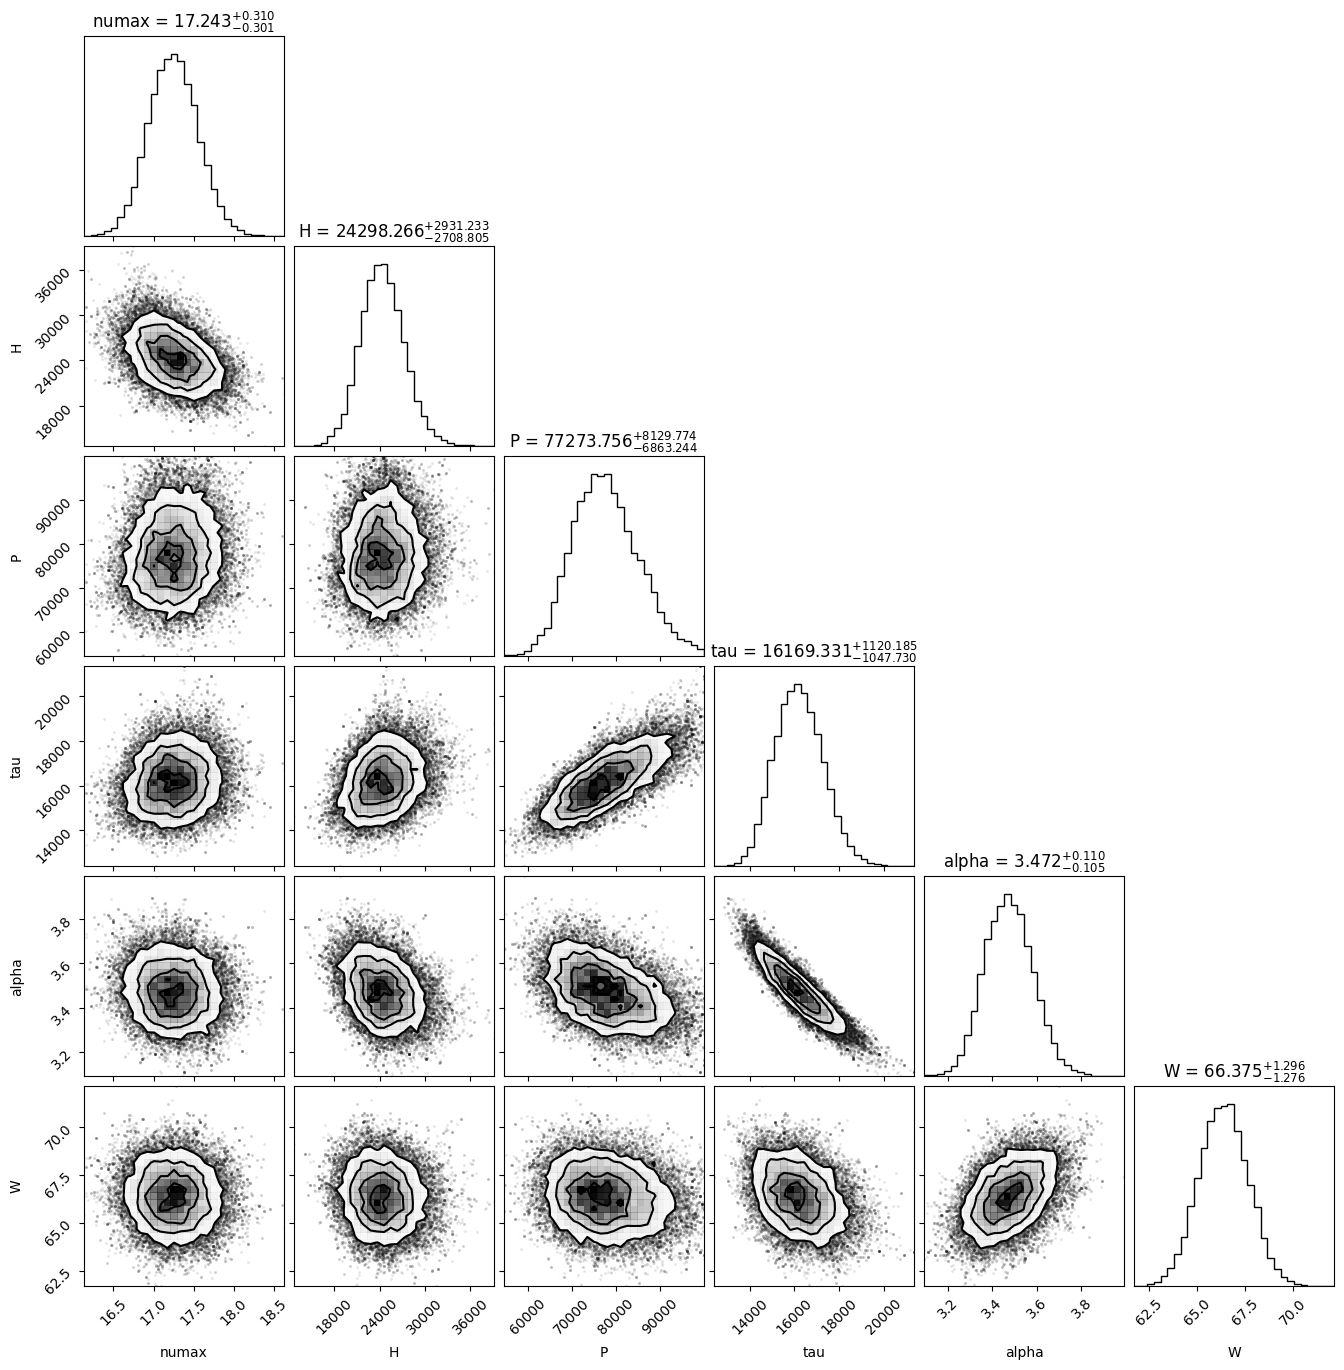

In [15]:
corner_plot(sampler)

In [ ]:
data = grab_data(int(table.iloc[2]["KIC"]))

theta = np.append(table.iloc[2][['nu_max', 'H', 'P', 'tau', 'alpha']], 10)
initial = np.array(theta)
p0 = [initial + bump * np.random.randn(ndim) for i in range(nwalkers)]

with Pool(cpu_count()) as pool:
    sampler, pos, prob, state = main(p0, data, pool)

get_cov(sampler, show = True)

In [4]:
table = pd.read_csv("/Users/student/Downloads/merged_data.csv")
nwalkers = 15
niter = 5000
ndim = 6

sampler_list = []
cov_list = []
bump = [1e-2 , 1e-2 , 1e-2 , 1e-2 ,1e-2, 1e-2]

for index, row in table.head(2).iterrows():
    data = grab_data(int(row["KIC"]))

    theta = np.append(row[['nu_max', 'H', 'P', 'tau', 'alpha']], 10)
    initial = np.array(theta)
    p0 = [initial + bump * np.random.randn(ndim) for i in range(nwalkers)]

    with Pool(cpu_count()) as pool:
        sampler, pos, prob, state = main(p0, data, pool)

    sampler_list.append(sampler)
    cov_list.append(get_cov(sampler, show = False))

Running burn-in...


100%|██████████| 1000/1000 [01:12<00:00, 13.78it/s]


Running production...


100%|██████████| 5000/5000 [05:26<00:00, 15.33it/s]


Running burn-in...


100%|██████████| 1000/1000 [00:14<00:00, 67.82it/s]


Running production...


100%|██████████| 5000/5000 [01:16<00:00, 65.25it/s]


In [ ]:
list = np.array(cov_list)
np.save("matrices", list)
list.shape

(2, 6, 6)

In [9]:
np.save("matrices", list)

In [ ]:
df = pd.DataFrame(np.vstack(cov_list))

df.to_csv("cov_matrices.csv", index=False, header=False)

# Getting plots 

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np 
import emcee
import corner

import matplotlib.pyplot as plt

from mcmc_utils_copy import posteriors, get_cov, corner_plot, check_convergence, lnprob

In [4]:
def load_sampler(r, samplers = None, ind = 0):

    if samplers is None: 
        samplers = np.load(f"runs/run {r}/samplers.npy", allow_pickle=True)

    return samplers[ind]

def grab_plots(r, samplers = None, offset = 0 ):

    if samplers is None: 
        samplers = np.load(f"runs/run {r}/samplers.npy", allow_pickle=True)

    for i in range(len(samplers)):

        s = samplers[i]
        cov = get_cov(s, show = True)
        plt.savefig(f"runs/run {r}/{i+ offset}_cov_matrix.png")
        plt.close()

        fig = corner_plot(s)
        fig.savefig(f"runs/run {r}/{i+ offset}_corner.png")
        plt.close(fig)

        check_convergence(s)
        plt.savefig(f"runs/run {r}/{i+ offset}_convergence.png")
        plt.close()

        posteriors(s, i+ offset)
        plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")
        plt.close()

        print(f"Star {i+ offset} is done.")

    return samplers

In [ ]:
grab_plots(r = 16, offset = 20)

Star 20 is done.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_58567/143536064.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")


Star 21 is done.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_58567/143536064.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")


Star 22 is done.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_58567/143536064.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")


Star 23 is done.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_58567/143536064.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")


Star 24 is done.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_58567/143536064.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")


Star 25 is done.


/var/folders/wk/btl5__ws27j89zzfj9xyfnf80000gp/T/ipykernel_58567/143536064.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")


Star 26 is done.


In [ ]:
path = "/Users/student/Desktop/runs/run 16/results.npy"

results = np.load(path, allow_pickle=True)

In [28]:
results[0][2]

array([[ 1.        , -0.38375573,  0.05774724,  0.04765885,  0.03015685,
         0.08566169],
       [-0.38375573,  1.        ,  0.10436213,  0.21205343, -0.22279841,
        -0.06271306],
       [ 0.05774724,  0.10436213,  1.        ,  0.84852235, -0.59006896,
        -0.18865247],
       [ 0.04765885,  0.21205343,  0.84852235,  1.        , -0.89630718,
        -0.30212765],
       [ 0.03015685, -0.22279841, -0.59006896, -0.89630718,  1.        ,
         0.45580759],
       [ 0.08566169, -0.06271306, -0.18865247, -0.30212765,  0.45580759,
         1.        ]])

# Looking at Covariances

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from IPython.display import HTML
import ipywidgets as widgets

import numpy as np

In [ ]:
def animate_covariances(cov_list, save_path=None, interval=1000):

    param_names = ["nu_max", "H", "P", "tau", "alpha", "W"]

    fig, ax = plt.subplots(figsize=(6,6))
    discrete_viridis = ListedColormap(plt.cm.seismic(np.linspace(0, 1, 9)))

    im = ax.matshow(cov_list[0], cmap=discrete_viridis, vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(param_names)))
    ax.set_xticklabels(param_names, rotation=90)
    ax.set_yticks(np.arange(len(param_names)))
    ax.set_yticklabels(param_names)
    title = ax.set_title("Correlation Matrix (Star 0)", pad=20)
    plt.draw_if_interactive()

    def update(frame):
        im.set_data(cov_list[frame])
        title.set_text(f"Correlation Matrix (Star {frame})")
        return [im, title]

    ani = animation.FuncAnimation(fig, update, frames=len(cov_list), interval=interval, blit=False)

    if save_path:
        if save_path.endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=1000//interval)
        elif save_path.endswith(".mp4"):
            ani.save(save_path, writer="ffmpeg", fps=1000//interval)
        else:
            raise ValueError("Unsupported file format. Use .gif or .mp4")

    plt.close(fig) 
    return HTML(ani.to_jshtml())


In [56]:
cov_list1 = np.array(np.load("/Users/student/Desktop/runs/run 15/cov_matrices.npy"))
cov_list2 = np.array(np.load("/Users/student/Desktop/runs/run 16/cov_matrices.npy"))

mask = np.ones(len(cov_list1) +len(cov_list2) , dtype=bool)
mask[[2, 5, 7, 12, 13, 16, 17]] = False
cov_list = (np.concat((cov_list1, cov_list2)))[mask]

animate_covariances(cov_list, save_path="covariances1.gif", interval=1000)

In [66]:
def matrix_element(n, m, printt = False, plot = False):
    Mnm = cov_list[:, n, m]
    mu , std = np.mean(Mnm) ,  np.std(Mnm)

    if printt: 
        print(f"mean of M{n, m}: {mu}")
        print(f"std of M{n, m}: {std}")

    if plot:
        plt.hist(Mnm , bins = 7)

    return Mnm, mu, std

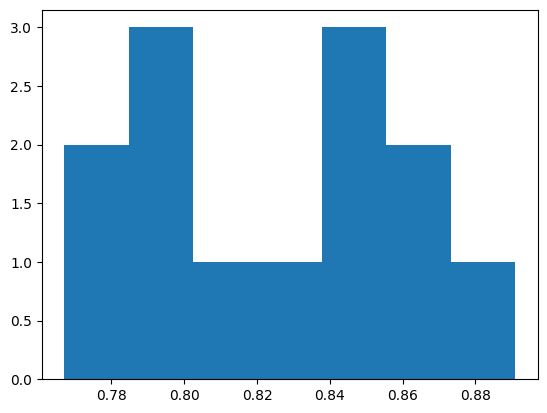

In [70]:
Mnm, mu, std = matrix_element(2, 3, plot = True)
#Mnm, mu, std = matrix_element(2, 3, printt = True)

In [49]:
inds = []

for ii in range(6):
    for jj in range(ii):
        if not (ii == jj):
            m , mean , std = matrix_element(ii, jj)

            if (np.abs(std) < 0.3):
                print(ii , jj, mean, std )
                inds.append([ii, jj])

1 0 -0.37672065980097635 0.06131421739222421
2 0 -0.004417511180100085 0.0609711908461272
2 1 0.12168795088509562 0.09339261523267979
3 0 -0.02631181448812555 0.09611952778626622
3 1 0.24761987885945538 0.16381108737889874
3 2 0.8312256140094869 0.03863123136632117
4 0 0.07115596867036371 0.10356349590928347
4 1 -0.22106380953695925 0.22722226784436905
4 2 -0.5468367148710258 0.04203780266478841
4 3 -0.8814083099993976 0.0267422060661723
5 0 0.05646043057619187 0.047491393834580224
5 1 -0.03670253761152979 0.13562090336081695
5 2 -0.22533164844364048 0.07578953501985074
5 3 -0.36066337311730673 0.08574408507199421
5 4 0.5232674940825582 0.10884006646676797


In [47]:
np.array(inds).shape

(4, 2)